In [ ]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(rc = {'figure.figsize':(15,8)})
plt.rcParams['savefig.dpi'] = 200

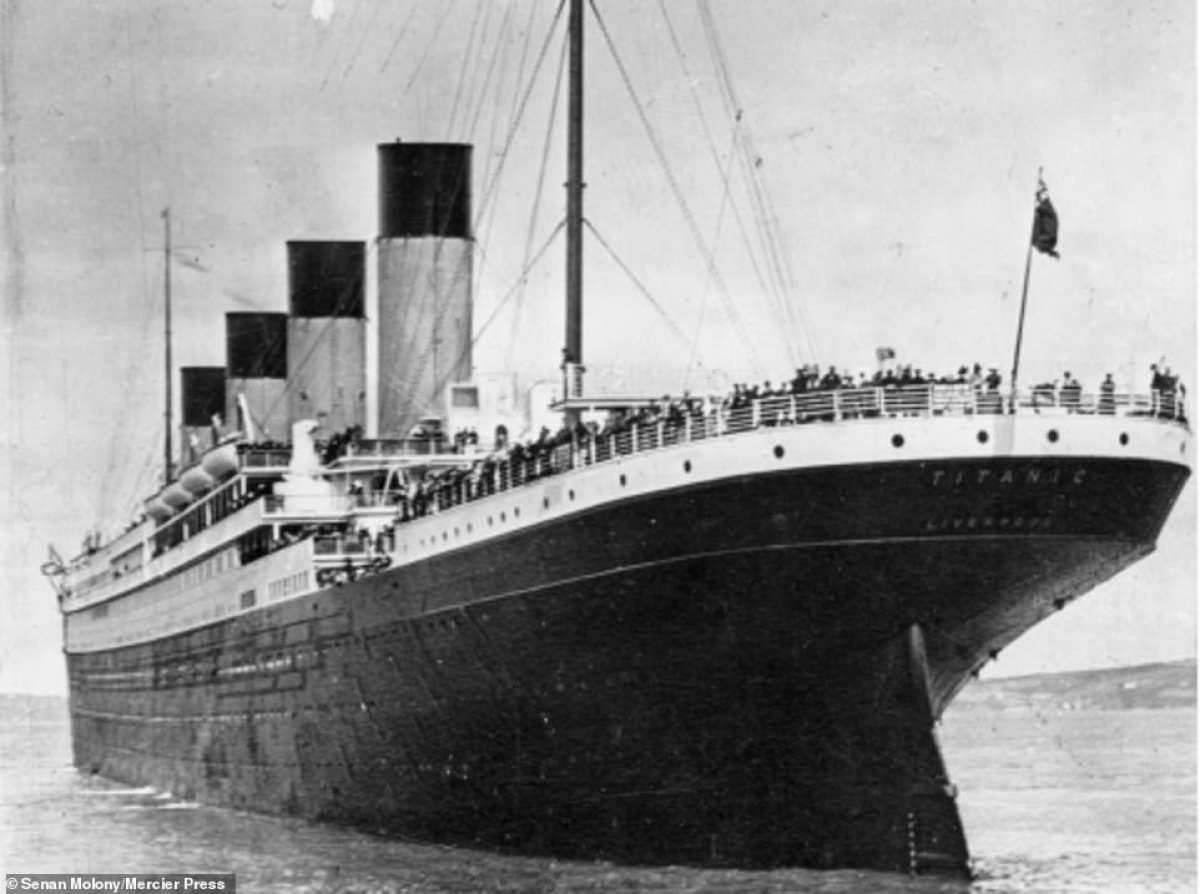

# 1. Load data

In [ ]:
train = pd.read_csv(r'../input/titanic/train.csv')
test = pd.read_csv(r'../input/titanic/test.csv')
train.head(5)

In [ ]:
# set index to PassengerID
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

In [ ]:
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

Notice that **Age, Cabin, Fare and Embarked** have some missing values.. We need to deal with them.

In [ ]:
train.describe().round(2).T

# 2. Missing values

**Concat train, test to whole dataset for convenient**

In [ ]:
data=pd.concat([train, test])
print(data.shape)

> ## 2.1 Age

**We need to replace all null ages based on title and average age by title.**

In [ ]:
print("Number of null ages:", data["Age"].isnull().sum())

In [ ]:
def fill_age(data):
    
    # Frist, extract title from names
    data['Initial']=0
    for i in data:
        data['Initial'] = data["Name"].str.extract('([A-Za-z]+)\.')
    
    # Second, replace them to Mr, Mrs, Miss or Other
    data["Initial"] = data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                                               'Rev','Capt','Sir','Don', 'Dona'],
                                              ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other',
                                               'Mr','Mr','Mr', 'Mrs']
                                             )
    
    # Third,compute the average age of each title.
    age_mean = data.groupby('Initial')['Age'].mean().map(np.ceil)
    
    # Finally, assign the null values with the ceil values of the mean age.
    for idx, val in zip(age_mean.index, age_mean.values):
        for i in data:
            data.loc[(data["Age"].isnull())&(data["Initial"]==idx),"Age"] = val
    
    return data

In [ ]:
data = fill_age(data=data)
print("Is there any null value for age? -", data.Age.isnull().any())

> ## 2.2 Embarked 

In [ ]:
print("Number of null embarked:", data["Embarked"].isnull().sum())

In [ ]:
data["Embarked"].value_counts()

Note: (C = Cherbourg; Q = Queenstown; S = Southampton)   
Most of passengers came from Southampton, we can simply replace missing values of **"Embarked"** to **"S"**

In [ ]:
data.loc[data["Embarked"].isnull(), "Embarked"] = "S"
print("Is there any null value for embarked? -", data.Embarked.isnull().any())

> ## 2.3 Fare

In [ ]:
print("Number of null fare:", data["Fare"].isnull().sum())

Simply replace null values of fare with average...

In [ ]:
data.loc[data["Fare"].isnull(), "Fare"] = data.Fare.mean().round(4)
print("Is there any null value for embarked? -", data.Embarked.isnull().any())

> ## 2.4. Cabin

In [ ]:
print("Number of null 'cabin':", data["Cabin"].isnull().sum())
# Look at various type of cabins
print(data["Cabin"].value_counts())

I'll accept null values for cabins..

**Now, I'll split the whole data to train set and test set as before.**

In [ ]:
# Convert some columns to int
data[["Pclass","Age","SibSp","Parch"]] = data[["Pclass","Age","SibSp","Parch"]].astype("int64")

# Split to train and test again..
train = data[data.index.isin(train.index)]
test  = data[data.index.isin(test.index)]

# Check
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

# 3. EDA

In [ ]:
color = "#5580cc"
palette=["#eb4255", "#2f9286"]

> ## 3.1. Survived percentage

In [ ]:
train['Survived'] = train['Survived'].astype("int64")

In [ ]:
fig ,ax = plt.subplots(1,1,figsize=(6,6))

train['Survived'].value_counts().plot.pie(explode=[0,0.1],
                                          autopct='%1.1f%%',
                                          ax=ax,
                                          colors = palette,
                                          center = (10,0),
                                          shadow=True)

ax.set_title('Percentage number of survived passengers')
ax.set_ylabel('')

> ## 3.2 Sex and Age

In [ ]:
fig ,ax=plt.subplots(1,2,figsize=(16,7))
train['Sex'].value_counts().plot.bar(color="#5580cc",ax=ax[0], xlabel="Sex")
ax[0].set_title('Number Of Passengers By Sex')
ax[0].set_ylabel('count')
sns.countplot('Sex', hue='Survived', data=train, ax=ax[1], palette=palette)
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,7))

# Dead
sns.histplot(data=train[train['Survived']==0],
             x='Age',bins=20,
             kde=True,
             kde_kws=dict(bw_adjust=1.5),
             legend=True,
             color='red',
             ax=ax[0])
ax[0].set_title("Distribution of age among Dead people")

# Alive
sns.histplot(data=train[train['Survived']==1],
             x='Age',bins=20,
             kde=True,
             kde_kws=dict(bw_adjust=1.5),
             legend=True,
             color='green',
             ax=ax[1])
ax[1].set_title("Distribution of age among Alive people")

In [ ]:
fig ,ax=plt.subplots(1,2,figsize=(16,7))
plt.suptitle("Distribution of ages among male and female passengers by Survived")

sns.histplot(x='Age', hue='Survived',
             data=train[train["Sex"]=="male"],
             multiple='stack',
             kde=True,
             kde_kws = dict(bw_adjust=1.5),
             ax=ax[0], palette=palette
            )

ax[0].set_title("Male passengers")

sns.histplot(x='Age', hue='Survived',
             data=train[train["Sex"]=="female"],
             multiple='stack',
             kde=True,
             kde_kws = dict(bw_adjust=1.5),
             ax=ax[1], palette=palette
            )

ax[1].set_title("Female passengers")

> ## 3.3 Title

In [ ]:
sns.factorplot('Initial','Survived', data=train);

> ## 3.4 Passenger class 

In [ ]:
fig ,ax=plt.subplots(1,2,figsize=(16,7))
train['Pclass'].value_counts().plot.bar(color="#5580cc",ax=ax[0], xlabel="Pclass")
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=train,ax=ax[1], palette=palette)
ax[1].set_title('Pclass: Survived vs Dead')
plt.show()

In [ ]:
sns.factorplot(data=train, x='Pclass', y='Survived',hue='Sex')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,7))

sns.violinplot(x="Pclass", y="Age",
               hue="Survived",
               data=train,
               split=True,
               ax=ax, palette=palette
              )

ax.set_title('Pclass and Age vs Survived')
ax.set_yticks(range(0,110,10));

> ## 3.5 Embarked 

In [ ]:
sns.countplot(data=train, x='Embarked',hue='Survived', palette = palette)

In [ ]:
sns.factorplot('Embarked','Survived',data=train);
fig = plt.gcf()
fig.set_size_inches(5,4);

In [ ]:
fig, ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=train,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=train,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=train,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=train,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

> ## 3.6 SibSp & Parch

Note:   
**sibsp** -> Number of Siblings/Spouses Aboard

**parch** -> Number of Parents/Children Aboard

In [ ]:
fig, ax=plt.subplots(1,2,figsize=(16,7))

sns.countplot(x='SibSp', hue='Survived', data=train, palette=palette, ax=ax[0])
sns.pointplot('SibSp','Survived',data=train, ax=ax[1]);

plt.suptitle("Survived and Sibling/Spouses aboard")

In [ ]:
fig, ax=plt.subplots(1,2,figsize=(16,7))

sns.countplot(x='Parch', hue='Survived', data=train, palette=palette, ax=ax[0])
sns.pointplot('Parch','Survived',data=train, ax=ax[1]);

plt.suptitle("Survived and Parent/Child aboard")

In [ ]:
train["Family_size"] = train["SibSp"] + train["Parch"]

fig, ax=plt.subplots(1,2,figsize=(16,7))

sns.countplot(x='Family_size', hue='Survived', data=train, palette=palette, ax=ax[0])
sns.pointplot('Family_size','Survived',data=train, ax=ax[1]);

plt.suptitle("Survived and family size")

> ## 3.7 Fare

In [ ]:
print('Highest Fare was:',train['Fare'].max())
print('Lowest Fare was:',train['Fare'].min())
print('Average Fare was:',train['Fare'].mean())

In [ ]:
f,ax=plt.subplots(1,3,figsize=(20,7))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

In [ ]:
sns.boxplot(y="Survived", x="Fare",
            data=train,
            orient = 'h',
            palette=palette)

plt.title("Box-plot of fare by Survived")

# 4. Build model

> ## 4.1 Encoding

In [ ]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'],[0,1,2,3,4],inplace=True)

In [ ]:
data["Family_size"] = data["SibSp"] + data["Parch"]

In [ ]:
df = data.copy()
df.drop(['Name','Ticket','Cabin', 'SibSp', 'Parch'],axis=1,inplace=True)
df.head()

> ## 4.2. Nomarlize data

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

minmax_scaler = MinMaxScaler()
df["Age"] = minmax_scaler.fit_transform(df["Age"].values.reshape(-1, 1))

rb_scaler = RobustScaler()
df["Fare"] = rb_scaler.fit_transform(df["Fare"].values.reshape(-1, 1))

In [ ]:
df.head()

In [ ]:
# Split train, test for submission
df_train = df[df.index.isin(train.index)]
df_test  = df[df.index.isin(test.index)]
df_test.drop("Survived", axis=1, inplace=True)

print("Train shape: ", df_train.shape)
print("Test shape: ", df_test.shape)

In [ ]:
X = df_train.drop('Survived',axis=1)
y = df_train["Survived"] 

In [ ]:
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.model_selection import cross_val_score, train_test_split 

# Importing metrics 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #for confusion matrix
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Tuning hyperparameters
from sklearn.model_selection import GridSearchCV

In [ ]:
# Split train data to train set and validate set
X_train,X_val, y_train,y_val = train_test_split(X, y, test_size=0.25, random_state=42)

print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_val.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_val.shape)

Then, I'll try different type of classification models and compared their's **Accuracy Score**

Logistic Regression, default params

In [ ]:
logr_model = LogisticRegression(C=10)
logr_model.fit(X, y)
y_pred = logr_model.predict(X_val)
print("========Logistic Regression output=========\n")
print(classification_report(y_val, y_pred))

Gaussian Naive Bayes, default params

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_val)
print(classification_report(y_val, y_pred))

K-Nearest Neighbors (k=5)

In [ ]:
knn = KNeighborsClassifier(5)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_val)
print(classification_report(y_val, y_pred))

In [ ]:
# Try an ensemble model - Voting Classifier
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('logr', logr_model),
                                    ('knn', knn), ('gnb', gnb)], voting='hard')

eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_val)
print(classification_report(y_val, y_pred))

In [ ]:
# Try another ensemble model - GradientBoosting Classifier

from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_val)
print(classification_report(y_val, y_pred))

In [ ]:
print(dict(zip(gbc.feature_names_in_, gbc.feature_importances_)))

Surprisingly, the accuracy score and F1-Score of **GBC** with default parameters was actually well compared to those models before.   
Next, I'll try tuning some important parameters to increase **Accuracy Score**.

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.8],
    "max_depth":[2,4,8,10],
    "max_features":["log2","sqrt"],
    "n_estimators":[10, 20,30,50,70,100],
    "min_samples_split":[2,4,6,8]
    }

#passing the scoring function in the GridSearchCV
clf = GridSearchCV(gbc,
                   param_grid=parameters,
                   scoring="accuracy",
                   cv=5,
                   verbose=1
                  )

Try: select only important features and fit to the model

In [ ]:
X_train_new = X_train.drop(columns=["Sex", "Age", "Embarked"])
X_val_new = X_val.drop(columns=["Sex", "Age", "Embarked"])

In [ ]:
clf.fit(X_train_new, y_train)

In [ ]:
print(clf.best_score_)

In [ ]:
y_pred = clf.predict(X_val_new)
print("==============GradientBoostingClassifier=============")
print(classification_report(y_val, y_pred))

In [ ]:
df_test = df_test.drop(columns=["Sex", "Age", "Embarked"])
df_test["Survived"] = clf.predict(df_test)

In [ ]:
output = df_test["Survived"]

In [ ]:
output.to_csv("./output_gbc2.csv")